In [258]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [224]:
sns.set(color_codes=True)

In [7]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

In [267]:
raw_html = simple_get(url = r'https://www.blocket.se/goteborg/bilar?cg=1020&w=1&st=s&ca=31&is=1&l=0&md=th&cb=7&cbl1=1')

In [268]:
html = BeautifulSoup(raw_html, 'html.parser')

In [109]:
item_links = html.find_all('a',attrs={'class':'item_link'})

In [216]:
item_link = item_links[0]
item_link['href']



'https://www.blocket.se/stockholm/Citroen_Berlingo_1_6_HDI_LANG_L2___AUTOMAT___80695149.htm?ca=11&w=1'

In [118]:
raw_html2 = simple_get(item_link['href'])
html2 = BeautifulSoup(raw_html2, 'html.parser')

In [131]:
header = html2.find('h1',attrs = {'h3 subject_small'})
name = header.text.replace('\n','').replace('\t','')
name


'Citroën Berlingo 1.6 HDI LÅNG L2 / AUTOMAT / -14'

In [133]:
item_details = html2.find('div',attrs = {'id':'item_details'})

In [135]:
items = item_details.find_all('dl',attrs={'class':'col-xs-4'})

In [138]:
item = items[0]

In [141]:
item

<dl class="col-xs-4">
<dt>Modellår</dt>
<dd><strong>2014</strong></dd>
</dl>

In [143]:
key = item.find('dt').text

'Modellår'

In [145]:
value = item.find('dd').text

In [218]:
def clean_string(s):
    s_clean = s.replace('\n','').replace('\t','')
    return s_clean

def clean_string2(s):
    s_clean = clean_string(s).replace(' ','')
    return s_clean

def clean_price(s):
    s_clean = clean_string(s)
    s_clean = s_clean.replace('kr','').replace(' ','')
    price = float(s_clean)
    return price

def find_id_from_href(href):
    
    result = re.search(pattern = r'(\d*).htm',string = href)
    id = int(result.groups(1)[0])
    return id
    
def parse_car(href):
    
    raw_html = simple_get(item_link['href'])
    html = BeautifulSoup(raw_html, 'html.parser')
    
    header = html.find('h1',attrs = {'h3 subject_small'})
    name = clean_string(header.text)
    
    item_details = html.find('div',attrs = {'id':'item_details'})
    items = item_details.find_all('dl',attrs={'class':'col-xs-4'})
    
    data = pd.Series()
    for item in items:
        key = clean_string2(item.find('dt').text)
        value = clean_string2(item.find('dd').text)
        data[key] = value
        
    data['header'] = name
    data.name = find_id_from_href(href = item_link['href'])
    
    price = html.find('div',attrs={'id':'vi_price'})
    data['price'] = clean_price(price.text)
    
    return data
        
    
        

In [219]:
parse_car(href = item_link['href'])

Modellår                                                       2014
Växellåda                                                   Automat
Miltal                                                         6500
Tillverkningsår                                                2013
Bränsle                                                      Diesel
header             Citroën Berlingo 1.6 HDI LÅNG L2 / AUTOMAT / -14
price                                                         68500
Name: 80695149, dtype: object

In [293]:
df_cars = pd.DataFrame()

next_page_href = r'https://www.blocket.se/goteborg/bilar?cg=1020&w=1&st=s&ca=31&is=1&l=0&md=th&cb=7&cbl1=1'

while not next_page_href is None:
    
    raw_html = simple_get(url = next_page_href)
    html = BeautifulSoup(raw_html, 'html.parser')
    item_links = html.find_all('a',attrs={'class':'item_link'})
    
    for item_link in item_links:
        
        try:
            s_car = parse_car(href = item_link['href'])
        except AttributeError:
            continue
        else:
            df_cars = df_cars.append(s_car)
        
    next_page = html.find('a',attrs = {'class':'page_nav'},text = '\n                Nästa sida »\n            ')
    if next_page is None:
        next_page_href = None
    else:
        next_page_href = r'https://www.blocket.se/goteborg/bilar' + next_page['href']


In [294]:
df_cars.head()

,Bränsle,Miltal,Modellår,Tillverkningsår,Växellåda,header,price
80806754,Diesel,5800,2015,2015,Manuell,Citroën Berlingo e-Hdi 90hk Propack/Webasto -15,92500.0
80804538,Diesel,4600,2013,-,Manuell,Citroën Berlingo III 1.6 HDi Drag *4600MIL* -13,64800.0
80801724,Diesel,1,2018,-,Manuell,Citroën Berlingo BlueHdi 100 HK L1 manuell *L -18,159875.0
80799934,Diesel,1,2017,2017,Automat,Citroën Berlingo L1 100HK Pro Pack AUT Giraff -17,156125.0
80810218,Bensin,0,2018,-,Manuell,Citroën Berlingo Pro Pack Edition + Frontbåge -18,181250.0


In [295]:
index = df_cars['Tillverkningsår'] == '-'
df_cars.loc[index,'Tillverkningsår'] = df_cars.loc[index,'Modellår']

In [296]:
float_cols = ['Miltal','Modellår','Tillverkningsår']
df_cars[float_cols] = df_cars[float_cols].astype(float)

In [297]:
df_cars.to_csv('cars.csv',sep = ';')

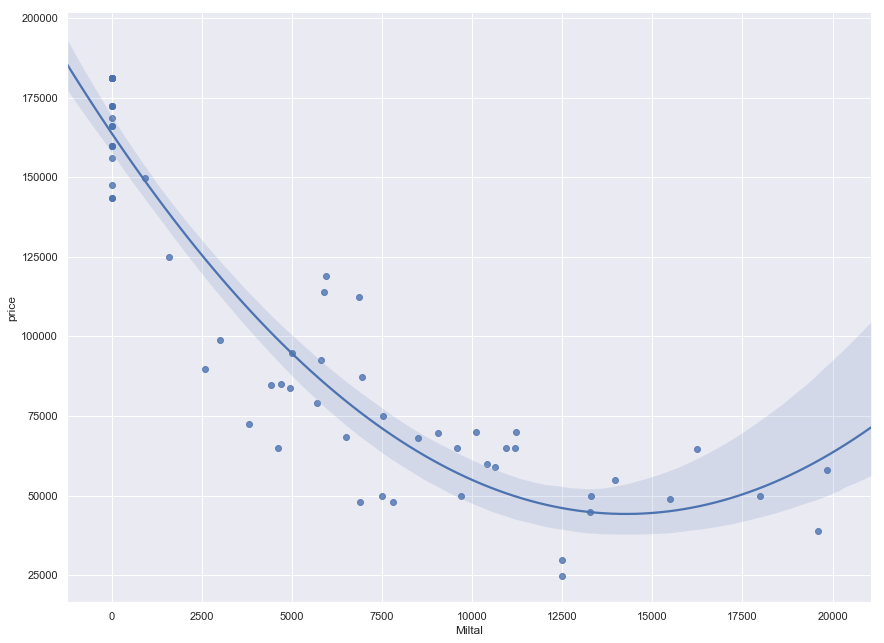

In [298]:
a = sns.lmplot(x="Miltal", y="price", data=df_cars,order=2)
a.fig.set_size_inches(15,10)

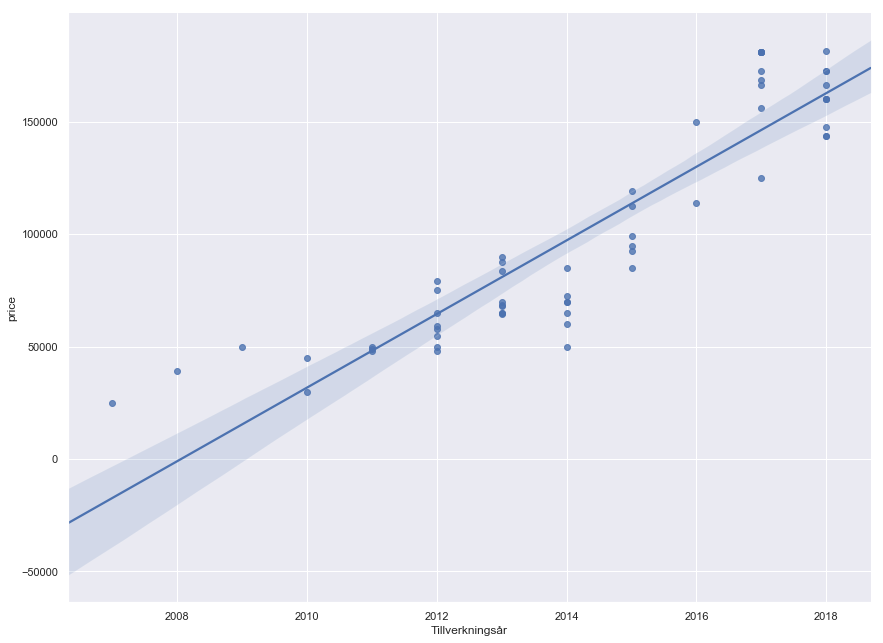

In [299]:
a = sns.lmplot(x="Tillverkningsår", y="price", data=df_cars)
a.fig.set_size_inches(15,10)